In [255]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import glob
from scipy.sparse import hstack
from sklearn.feature_extraction import stop_words

import matplotlib.pyplot as plt

# Classify data sharing

Eventually this will probably expand to encompass classifying bits of text in a variety of ways. At the moment, I've labeled some and am going to explore whether it's even feasible to build a classifier with the small amount of data I have (especially since there are so few positive cases). It seems likely that I'm going to be expanding the labeled data at some point.

In [304]:
labeled_files = glob.glob('output/labeled_data/*.csv')
df_labeled = pd.concat((pd.read_csv(f) for f in labeled_files))

ds_files = glob.glob('output/labeled_data/active_learning_labels/data_sharing*.csv')
od_files = glob.glob('output/labeled_data/active_learning_labels/open_data*.csv')
df_data_sharing_al = pd.concat((pd.read_csv(f) for f in ds_files))
df_open_data_al = pd.concat((pd.read_csv(f) for f in od_files))

df_pmcids = pd.read_csv('data/PMC-ids.csv')

/home/riddleta/ac_knowl/ac_knowl/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
/home/riddleta/ac_knowl/ac_knowl/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys
/home/riddleta/ac_knowl/ac_knowl/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4,5,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [309]:
df = pd.concat([df_labeled, df_data_sharing_al, df_open_data_al])
df.text.fillna('', inplace=True)
df.reset_index(inplace=True)

df['pmcid'] = df.pmcid.astype('str')
df['offset'] = df.paper_offset.astype('str')
df_pmcids['pmcid'] = df_pmcids.PMCID.apply(lambda x: str(x)[3:])
df = df.merge(df_pmcids, how='left', on='pmcid')
df['pmcid-offset'] = df.apply(lambda x: x['pmcid']+'-'+x['offset'], axis=1)

df.columns

/home/riddleta/ac_knowl/ac_knowl/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


Index(['index', 'data_sharing', 'doi', 'open_data', 'paper_offset', 'pmcid',
       'repo', 'section', 'text', 'offset', 'Journal Title', 'ISSN', 'eISSN',
       'Year', 'Volume', 'Issue', 'Page', 'DOI', 'PMCID', 'PMID',
       'Manuscript Id', 'Release Date', 'pmcid-offset'],
      dtype='object')

In [310]:
df_open_data = df[~pd.isnull(df.open_data)]
df_open_data['open_data'] = df_open_data.open_data.astype('int')
df_open_data.reset_index(inplace=True)
df_open_data.open_data.value_counts()

/home/riddleta/ac_knowl/ac_knowl/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    1167
1     184
Name: open_data, dtype: int64

In [311]:
df_data_sharing = df[~pd.isnull(df.data_sharing)]
df_data_sharing['data_sharing'] = df_data_sharing.data_sharing.astype('int')
df_data_sharing.reset_index(inplace=True)
df_data_sharing.data_sharing.value_counts()

/home/riddleta/ac_knowl/ac_knowl/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    1285
1      66
Name: data_sharing, dtype: int64

In [312]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
cv = CountVectorizer(stop_words=stop_words.ENGLISH_STOP_WORDS)
enc = OneHotEncoder(handle_unknown='ignore')

In [313]:
fold = 0

for train_index, test_index in kfold.split(df_data_sharing.text, df_data_sharing.data_sharing):
    x_train = cv.fit_transform(df_data_sharing.text[train_index])
    one_hots_train = enc.fit_transform(df_data_sharing[['section', 'Journal Title', 'Year']].iloc[train_index])
    y_train = df_data_sharing.data_sharing[train_index]
    x_test = cv.transform(df_data_sharing.text[test_index])
    one_hots_test = enc.transform(df_data_sharing[['section', 'Journal Title', 'Year']].iloc[test_index])
    y_test = df_data_sharing.data_sharing[test_index]
    
    x_train = hstack([x_train, one_hots_train])
    x_test = hstack([x_test, one_hots_test])
    
    clf = AdaBoostClassifier()
    y_score = clf.fit(x_train, y_train).decision_function(x_test)
    y_pred = clf.predict(x_test)
    print('***** fold {} *****'.format(fold))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    fold = fold + 1

***** fold 0 *****
[[424   5]
 [ 14   8]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       429
           1       0.62      0.36      0.46        22

    accuracy                           0.96       451
   macro avg       0.79      0.68      0.72       451
weighted avg       0.95      0.96      0.95       451

***** fold 1 *****
[[423   5]
 [ 10  12]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       428
           1       0.71      0.55      0.62        22

    accuracy                           0.97       450
   macro avg       0.84      0.77      0.80       450
weighted avg       0.96      0.97      0.96       450

***** fold 2 *****
[[421   7]
 [ 12  10]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       428
           1       0.59      0.45      0.51        22

    accuracy                           0.96       450
  

In [316]:
fold = 0
for train_index, test_index in kfold.split(df_open_data.text, df_open_data.open_data):
    x_train = cv.fit_transform(df_open_data.text[train_index])
    one_hots_train = enc.fit_transform(df_open_data[['section', 'Journal Title', 'Year']].iloc[train_index])
    y_train = df_open_data.open_data[train_index]
    x_test = cv.transform(df_open_data.text[test_index])
    one_hots_test = enc.transform(df_open_data[['section', 'Journal Title', 'Year']].iloc[test_index])
    y_test = df_open_data.open_data[test_index]
    
    x_train = hstack([x_train, one_hots_train])
    x_test = hstack([x_test, one_hots_test])
    
    clf = AdaBoostClassifier()
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print('***** fold {} *****'.format(fold))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    fold = fold + 1

***** fold 0 *****
[[384   5]
 [ 24  38]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       389
           1       0.88      0.61      0.72        62

    accuracy                           0.94       451
   macro avg       0.91      0.80      0.84       451
weighted avg       0.93      0.94      0.93       451

***** fold 1 *****
[[375  14]
 [ 24  37]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       389
           1       0.73      0.61      0.66        61

    accuracy                           0.92       450
   macro avg       0.83      0.79      0.81       450
weighted avg       0.91      0.92      0.91       450

***** fold 2 *****
[[382   7]
 [ 21  40]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       389
           1       0.85      0.66      0.74        61

    accuracy                           0.94       450
  

# Get some ROC curves

In [438]:
df_open_data = df[~pd.isnull(df.open_data)]
df_open_data['open_data'] = df_open_data.open_data.astype('int')
df_open_data.reset_index(inplace=True)
df_open_data.open_data.value_counts()
#df_open_data.columns
#pd.isnull(df_open_data.data_sharing).value_counts()
X_train, X_test, y_train, y_test = train_test_split(df_open_data.text, df_open_data.open_data, 
                                                    test_size=0.33, random_state=42, 
                                                    stratify=df_open_data.open_data)

/home/riddleta/ac_knowl/ac_knowl/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [439]:
cv = CountVectorizer(stop_words=stop_words.ENGLISH_STOP_WORDS)
enc = OneHotEncoder(handle_unknown='ignore')

In [440]:
x_train = cv.fit_transform(X_train)
one_hots_train = enc.fit_transform(df_open_data[['section', 'Journal Title', 'Year']].iloc[X_train.index])
x_test = cv.transform(X_test)
one_hots_test = enc.transform(df_open_data[['section', 'Journal Title', 'Year']].iloc[X_test.index])

x_train = hstack([x_train, one_hots_train])
x_test = hstack([x_test, one_hots_test])

clf = AdaBoostClassifier()
y_score = clf.fit(x_train, y_train).decision_function(x_test)
y_pred = clf.predict(x_test)
fpr,tpr,_ = roc_curve(y_test, y_score)
tmp_df = pd.DataFrame({'tpr':tpr,
                       'fpr':fpr,
                       'auc':auc(fpr,tpr),
                       'clf':'Adaboost',
                       'pred':'open_data'})

clf = MultinomialNB()
clf.fit(x_train, y_train)
y_score = clf.predict_proba(x_test)[:,1]
y_pred = clf.predict(x_test)
fpr2,tpr2,_ = roc_curve(y_test, y_score)
tmp_df2 = pd.DataFrame({'tpr':tpr2,
                       'fpr':fpr2,
                       'auc':auc(fpr2,tpr2),
                       'clf':'MultinomialNB',
                       'pred':'open_data'})
df_out = pd.concat([tmp_df, tmp_df2])

In [449]:
clf = AdaBoostClassifier()
y_score = clf.fit(x_train, y_train).decision_function(x_test)
y_pred = clf.predict(x_test)
df_egs = df_open_data.loc[X_test.index]
df_egs['y_pred'] = y_pred
df_egs[df_egs.open_data != df_egs.y_pred]
df_fp = df_egs[df_egs.open_data==1]
df_fp.text.iloc[8]

'All analyses were stratified by genetic ancestry. An outline of the primary analyses can be found in Supplemental Table S2 and more detailed descriptions of the planned analyses are provided in our published protocol. All code and documents relevant for running the analyses and meta-analysis are available in the public repository at https://github.com/achorton/SD_5HTTLPR.'

In [409]:
df_data_sharing = df[~pd.isnull(df.data_sharing)]
df_data_sharing['data_sharing'] = df_data_sharing.data_sharing.astype('int')
df_data_sharing.reset_index(inplace=True)
X_train, X_test, y_train, y_test = train_test_split(df_data_sharing.text, df_data_sharing.data_sharing, 
                                                    test_size=0.33, random_state=42, 
                                                    stratify=df_data_sharing.data_sharing)

/home/riddleta/ac_knowl/ac_knowl/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [410]:
x_train = cv.fit_transform(X_train)
one_hots_train = enc.fit_transform(df_data_sharing[['section', 'Journal Title', 'Year']].iloc[X_train.index])
x_test = cv.transform(X_test)
one_hots_test = enc.transform(df_data_sharing[['section', 'Journal Title', 'Year']].iloc[X_test.index])

x_train = hstack([x_train, one_hots_train])
x_test = hstack([x_test, one_hots_test])

clf = AdaBoostClassifier()
y_score = clf.fit(x_train, y_train).decision_function(x_test)
y_pred = clf.predict(x_test)
fpr,tpr,_ = roc_curve(y_test, y_score)
tmp_df = pd.DataFrame({'tpr':tpr,
                       'fpr':fpr,
                       'auc':auc(fpr,tpr),
                       'clf':'Adaboost',
                       'pred':'data_sharing'})

clf = MultinomialNB()
clf.fit(x_train, y_train)
y_score = clf.predict_proba(x_test)[:,1]
y_pred = clf.predict(x_test)
fpr2,tpr2,_ = roc_curve(y_test, y_score)
tmp_df2 = pd.DataFrame({'tpr':tpr2,
                       'fpr':fpr2,
                       'auc':auc(fpr2,tpr2),
                       'clf':'MultinomialNB',
                       'pred':'data_sharing'})
df_out = pd.concat([df_out, tmp_df, tmp_df2])

In [435]:
clf = AdaBoostClassifier()
y_score = clf.fit(x_train, y_train).decision_function(x_test)
y_pred = clf.predict(x_test)
df_egs = df_data_sharing.loc[X_test.index]
df_egs['y_pred'] = y_pred
df_egs[df_egs.data_sharing != df_egs.y_pred]
df_fp = df_egs[df_egs.data_sharing==1]
df_fp.text.iloc[2]

'Author information: Data included in this manuscript has been deposited at dbGaP under accession number phs000298.v1.p1 and is available for download at http://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/study.cgi?study_id=phs000298.v1.p1'

No handles with labels found to put in legend.


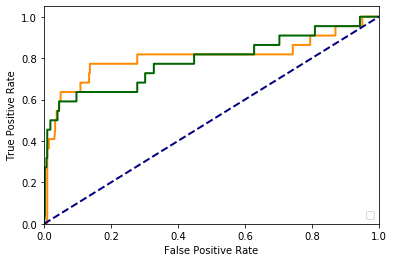

In [413]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot(fpr2, tpr2, color='darkgreen',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [323]:
df_out.to_csv('output/clf_scores.csv', index=False)